<a href="https://colab.research.google.com/github/Thamel777/Weather_Analysis/blob/main/Weather_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Weather Analysis") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

### ***Upload the CSV file and get informations using it ***
1. Show the schema
2. Preview first few rows
3. Calculating Missing values
4. Show data
5. Collect Temperature and create histogram using it's data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GlobalWeatherRepository.csv to GlobalWeatherRepository.csv


# World Weather Repository ( Daily Updating )
This dataset provides daily weather information for capital cities around the world. Unlike forecast data, this dataset offers a comprehensive set of features that reflect the current weather conditions around the world.
Starting from August 29, 2023.
It provides over 40+ features , including temperature, wind, pressure, precipitation, humidity, visibility, air quality measurements and more. The dataset is valuable for analyzing Global weather patterns, exploring climate trends, and understanding the relationships between different weather parameters.

1. PySpark

2. Google Colab Libraries
Import: from google.colab import files
Usage: uploaded = files.upload()

3. Pandas
Purpose: Convert PySpark DataFrames into Pandas DataFrames for easier plotting and manipulation.

4. Matplotlib
Purpose: Visualize data with histograms, box plots, line charts, and scatter plots.

5. Seaborn
Purpose: Create a correlation heatmap for visualizing relationships between variables.

6. Geopandas (Optional if mapping was used)
Purpose: Plot geographical maps if location-based visualizations are included.

7. Additional PySpark Functions
Functions: Used for statistical calculations and aggregations, such as mean, stddev, count, and approxQuantile.

8. Plotly
Plotly is a powerful visualization library for creating interactive plots and maps, making it useful for projects that require dynamic or web-based visualizations.

In [ ]:
file_path = "GlobalWeatherRepository.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema and preview the first few rows
data.printSchema()
data.show(5)

root
 |-- country: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- timezone: string (nullable = true)
 |-- last_updated_epoch: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- temperature_celsius: double (nullable = true)
 |-- temperature_fahrenheit: double (nullable = true)
 |-- condition_text: string (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- pressure_in: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- precip_in: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- feels_like_celsius: double (nullable = true)
 |-- feels_like_fahrenheit: double (nullable = true)
 |-- visibility_km: d

In [ ]:
from pyspark.sql.functions import col, sum

# Replace '.' in column names with '_' to avoid the issue
for column in data.columns:
  if '.' in column:
    data = data.withColumnRenamed(column, column.replace('.', '_'))

# Now calculate missing values
missing_data = data.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in data.columns])
missing_data.show()

+-------+-------------+--------+---------+--------+------------------+------------+-------------------+----------------------+--------------+--------+--------+-----------+--------------+-----------+-----------+---------+---------+--------+-----+------------------+---------------------+-------------+----------------+--------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+-----------------+----------------+------------------------+--------------------------+-------+------+--------+-------+----------+-----------------+
|country|location_name|latitude|longitude|timezone|last_updated_epoch|last_updated|temperature_celsius|temperature_fahrenheit|condition_text|wind_mph|wind_kph|wind_degree|wind_direction|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feels_like_celsius|feels_like_fahrenheit|visibility_km|visibility_miles|uv_index|gust_mph|gust_kph|air_quality_Carbon_Monoxide|air_quality_Ozone|air_quality_Ni

In [ ]:
data.show()

+-------------------+----------------+--------+---------+--------------------+------------------+-------------------+-------------------+----------------------+--------------------+--------+--------+-----------+--------------+-----------+-----------+---------+---------+--------+-----+------------------+---------------------+-------------+----------------+--------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+-----------------+----------------+------------------------+--------------------------+--------+--------+--------+----------+--------------+-----------------+
|            country|   location_name|latitude|longitude|            timezone|last_updated_epoch|       last_updated|temperature_celsius|temperature_fahrenheit|      condition_text|wind_mph|wind_kph|wind_degree|wind_direction|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feels_like_celsius|feels_like_fahrenheit|visibility_km|visibility_mil

This part of the analysis focuses on understanding the distribution and spread of temperature data within our dataset. By visualizing the data with a histogram and a box plot, we can gain insights into the central tendency, variability, and any potential outliers in the temperature values.

# Temperature Distribution Analysis

1.  Objective:

To analyze the distribution of temperature data and identify patterns or anomalies that may indicate specific weather characteristics or extremes in our dataset.

2.  Histogram:

The histogram displays the frequency of temperature values, allowing us to see how temperatures are distributed across the dataset. This can help identify whether the temperature data follows a normal distribution, if there are common temperature ranges, or if there is any skew in the data.


3.   Box Plot:

The box plot provides a summary of the temperature data, showing key statistical values: the median, quartiles, and potential outliers. This visualization highlights the central values and spread, giving a clear picture of any extreme values or variability in temperatures.






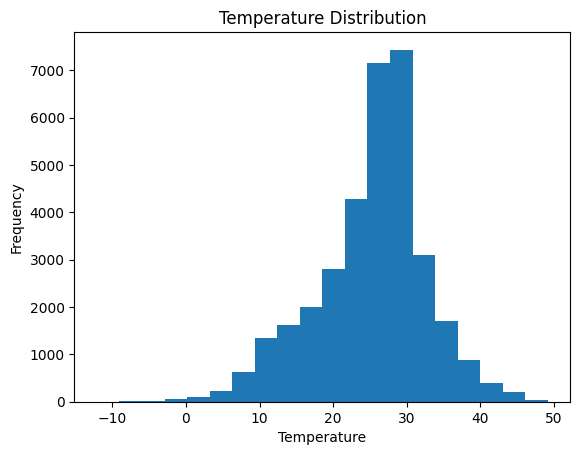

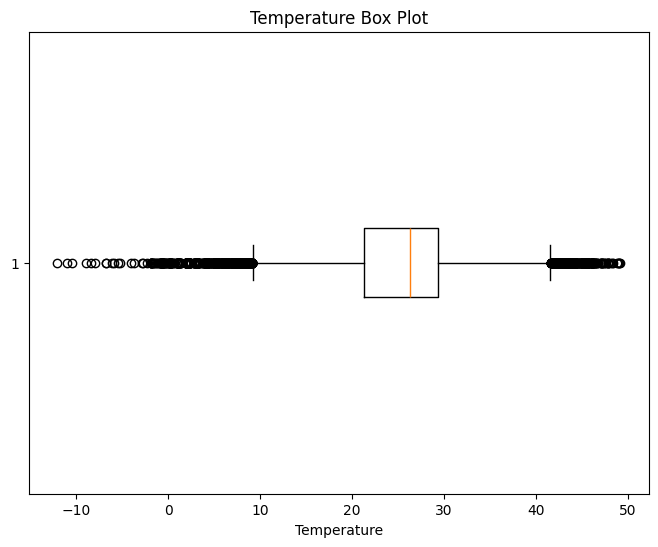

In [ ]:
import matplotlib.pyplot as plt

# Collect 'temperature_celsius' data for plotting
temperature_data = data.select("temperature_celsius").dropna().rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.hist(temperature_data, bins=20)
plt.title("Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(temperature_data, vert=False)
plt.title("Temperature Box Plot")
plt.xlabel("Temperature")
plt.show()


# Basic Statistics
This part of the analysis focuses on calculating key summary statistics for the temperature data in our dataset. Summary statistics provide an overall picture of the data’s central tendency, spread, and variability, which are essential for understanding the distribution and typical values of temperature measurements. Here’s a breakdown of each step:

Calculate Mean and Standard Deviation

In [ ]:
from pyspark.sql.functions import mean, stddev

# Calculate mean and standard deviation for the 'temperature_celsius' column
data.select(mean("temperature_celsius").alias("Mean_Temperature"), stddev("temperature_celsius").alias("StdDev_Temperature")).show()

+------------------+------------------+
|  Mean_Temperature|StdDev_Temperature|
+------------------+------------------+
|25.265158077726937| 7.383823778946095|
+------------------+------------------+



Calculate Median

In [ ]:
# Calculate median (50th percentile) for the 'temperature_celsius' column
median_temperature = data.approxQuantile("temperature_celsius", [0.5], 0.01)
print(f"Median Temperature: {median_temperature[0]}")


Median Temperature: 26.3


Calculate Mode

In [ ]:
from pyspark.sql.functions import count

# Calculate mode for the 'temperature_celsius' column
mode_temperature = data.groupBy("temperature_celsius").count().orderBy("count", ascending=False).first()
print(f"Mode Temperature: {mode_temperature['temperature_celsius']} with count: {mode_temperature['count']}")


Mode Temperature: 28.0 with count: 572


Calculate Additional Statistics for All Numeric Columns

In [ ]:
# Get summary statistics for all numeric columns
data.describe().show()


+-------+-----------+-----------------+------------------+------------------+-----------------+--------------------+-------------------+----------------------+--------------------+------------------+------------------+------------------+--------------+------------------+------------------+-------------------+--------------------+-----------------+-----------------+------------------+---------------------+-----------------+------------------+------------------+------------------+------------------+---------------------------+------------------+----------------------------+---------------------------+------------------+-----------------+------------------------+--------------------------+--------+--------+-----------+----------+--------------+-----------------+
|summary|    country|    location_name|          latitude|         longitude|         timezone|  last_updated_epoch|temperature_celsius|temperature_fahrenheit|      condition_text|          wind_mph|          wind_kph|       wind_

Collect Data for Visualization

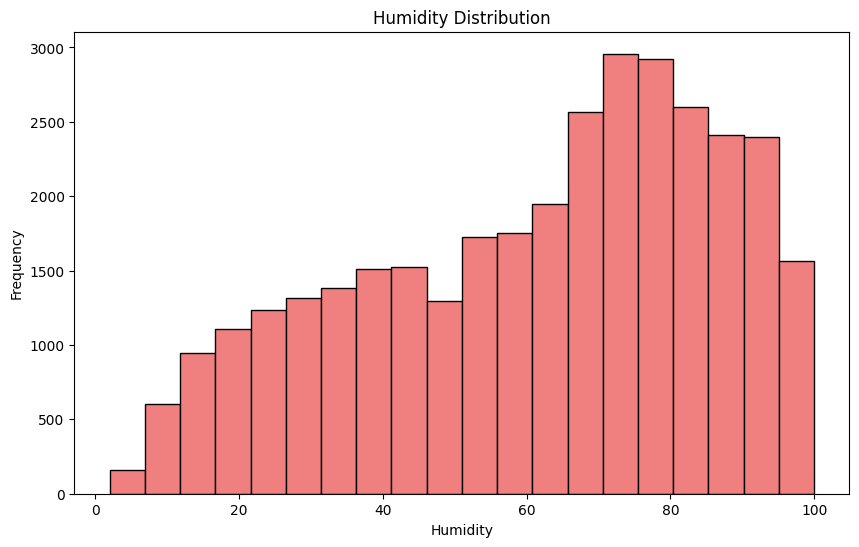

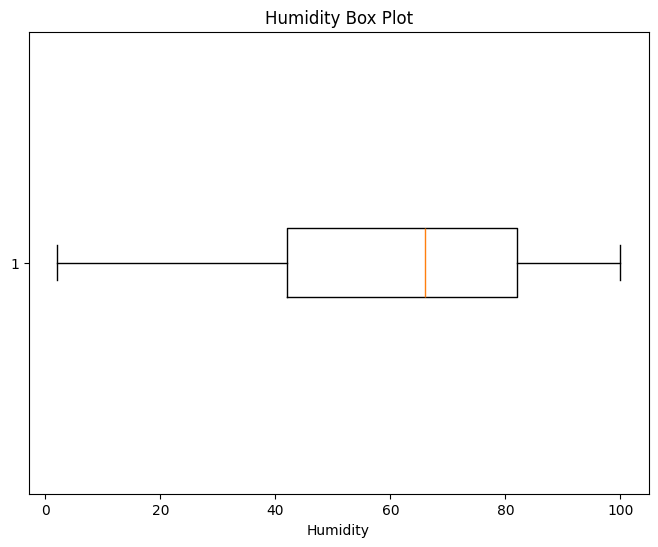

In [ ]:
# Collect and plot data for 'Humidity'
humidity_data = data.select("Humidity").dropna().rdd.flatMap(lambda x: x).collect()

# Plot histogram for Humidity
plt.figure(figsize=(10, 6))
plt.hist(humidity_data, bins=20, color='lightcoral', edgecolor='black')
plt.title("Humidity Distribution")
plt.xlabel("Humidity")
plt.ylabel("Frequency")
plt.show()

# Plot box plot for Humidity
plt.figure(figsize=(8, 6))
plt.boxplot(humidity_data, vert=False)
plt.title("Humidity Box Plot")
plt.xlabel("Humidity")
plt.show()


# Average of Numeric Columns Grouped by a Categorical Column
Calculate the average temperature and humidity for each country:

In [ ]:
# Average Temperature and Humidity by country
average_temp_humidity_by_region = data.groupBy("country").agg(
    mean("temperature_celsius").alias("Average_Temperature"),
    mean("Humidity").alias("Average_Humidity")
)

average_temp_humidity_by_region.show()

+-----------+-------------------+------------------+
|    country|Average_Temperature|  Average_Humidity|
+-----------+-------------------+------------------+
|       Chad|  32.83999999999999| 51.73142857142857|
|       Inde|               31.2|              71.0|
|   Südkorea|               26.1|              84.0|
|   Paraguay| 20.759428571428572|53.142857142857146|
|     Russia| 20.277659574468075|53.111702127659576|
|   Marrocos|               40.3|              14.0|
|      Yemen| 24.581034482758607| 27.57471264367816|
|    Senegal| 27.882857142857144|             77.08|
|     Sweden| 18.141379310344828|60.275862068965516|
|   Kiribati| 28.526589595375714| 72.40462427745665|
|     Guyana| 26.628323699421966| 87.84393063583815|
|    Polônia|               27.7|              52.0|
|    Eritrea| 22.807428571428566| 44.17142857142857|
|Philippines|  29.03160919540229| 81.09770114942529|
|   Djibouti|  35.31098265895954| 50.05780346820809|
|      Tonga| 22.149714285714285| 85.451428571

Sum of Numeric Columns Grouped by a Categorical Column

In [ ]:
# Sum Temperature and Humidity by Region
sum_temp_humidity_by_region = data.groupBy("country").agg(
    sum("temperature_celsius").alias("Total_Temperature"),
    sum("Humidity").alias("Total_Humidity")
)
sum_temp_humidity_by_region.show()

+-----------+------------------+--------------+
|    country| Total_Temperature|Total_Humidity|
+-----------+------------------+--------------+
|       Chad| 5746.999999999998|          9053|
|       Inde|              31.2|            71|
|   Südkorea|              26.1|            84|
|   Paraguay|            3632.9|          9300|
|     Russia| 3812.199999999998|          9985|
|   Marrocos|              40.3|            14|
|      Yemen| 4277.099999999998|          4798|
|    Senegal|            4879.5|         13489|
|     Sweden|            3156.6|         10488|
|   Kiribati|4935.0999999999985|         12526|
|     Guyana|            4606.7|         15197|
|    Polônia|              27.7|            52|
|    Eritrea|3991.2999999999993|          7730|
|Philippines| 5051.499999999998|         14111|
|   Djibouti|            6108.8|          8660|
|      Tonga|            3876.2|         14954|
|   Malaysia| 4998.599999999999|         13593|
|  Singapore|5073.0999999999985|        

Minimum and Maximum Values Grouped by a Categorical Column

In [ ]:
from pyspark.sql.functions import min, max, mean, sum

# Min and Max Temperature and Humidity by Region
min_max_temp_humidity_by_region = data.groupBy("country").agg(
    min("temperature_celsius").alias("Min_Temperature"),
    max("temperature_celsius").alias("Max_Temperature"),
    min("humidity").alias("Min_Humidity"),
    max("humidity").alias("Max_Humidity")
)

# Show the results
min_max_temp_humidity_by_region.show()

+-----------+---------------+---------------+------------+------------+
|    country|Min_Temperature|Max_Temperature|Min_Humidity|Max_Humidity|
+-----------+---------------+---------------+------------+------------+
|       Chad|           23.1|           45.0|           5|         100|
|       Inde|           31.2|           31.2|          71|          71|
|   Südkorea|           26.1|           26.1|          84|          84|
|   Paraguay|            9.0|           32.5|          18|          98|
|     Russia|           -0.9|           32.2|          21|         100|
|   Marrocos|           40.3|           40.3|          14|          14|
|      Yemen|           18.6|           29.4|           5|          67|
|    Senegal|           22.0|           32.3|          62|         100|
|     Sweden|            3.2|           28.2|          18|         100|
|   Kiribati|           27.3|           29.6|          63|          81|
|     Guyana|           24.0|           31.4|          69|      

Multiple Aggregations on Numeric Columns Grouped by a Categorical Column

In [ ]:
from pyspark.sql.functions import avg, sum, min, max # Import the necessary functions

# Multiple aggregations: avg, sum, min, max for Temperature and Humidity by Region
data.groupBy("country").agg(
    avg("temperature_celsius").alias("Avg_temperature_celsius"),
    sum("temperature_celsius").alias("Sum_temperature_celsius"),
    min("temperature_celsius").alias("Min_temperature_celsius"),
    max("temperature_celsius").alias("Max_temperature_celsius"),
    avg("Humidity").alias("Avg_Humidity"),
    sum("Humidity").alias("Sum_Humidity"),
    min("Humidity").alias("Min_Humidity"),
    max("Humidity").alias("Max_Humidity")
).show()

+-----------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+------------+------------+------------+
|    country|Avg_temperature_celsius|Sum_temperature_celsius|Min_temperature_celsius|Max_temperature_celsius|      Avg_Humidity|Sum_Humidity|Min_Humidity|Max_Humidity|
+-----------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+------------+------------+------------+
|       Chad|      32.83999999999999|      5746.999999999998|                   23.1|                   45.0| 51.73142857142857|        9053|           5|         100|
|       Inde|                   31.2|                   31.2|                   31.2|                   31.2|              71.0|          71|          71|          71|
|   Südkorea|                   26.1|                   26.1|                   26.1|                   26.1|              84.0|          84|          84|      

In [ ]:
# Programmatically apply aggregations to all columns
numeric_cols = [col for col, dtype in data.dtypes if dtype in ('int', 'double')]  # Select numeric columns only

# Create a dictionary of aggregations for each numeric column
agg_dict = {col: "avg" for col in numeric_cols}  # Example: average for all numeric columns

# Perform grouped aggregation by Region
data.groupBy("country").agg(agg_dict).show()


+-----------+------------------+------------------+--------------------+------------------+---------------------+-------------------+----------------------+-------------------------------+-----------------------------+-------------------+------------------+---------------------------+------------------+------------------+------------------+------------------------+---------------------------------+-----------------------+---------------------+--------------------------+----------------------+--------------------------------+------------------+----------------------+------------------+--------------------+--------------------------------+------------------+-----------------------+------------------+
|    country|     avg(wind_kph)|  avg(wind_degree)|      avg(precip_in)|     avg(gust_mph)|avg(air_quality_PM10)|      avg(latitude)|avg(air_quality_Ozone)|avg(air_quality_gb-defra-index)|avg(air_quality_us-epa-index)|     avg(longitude)|     avg(gust_kph)|avg(temperature_fahrenheit)|     av

Line Charts: Plotting Time Series Data

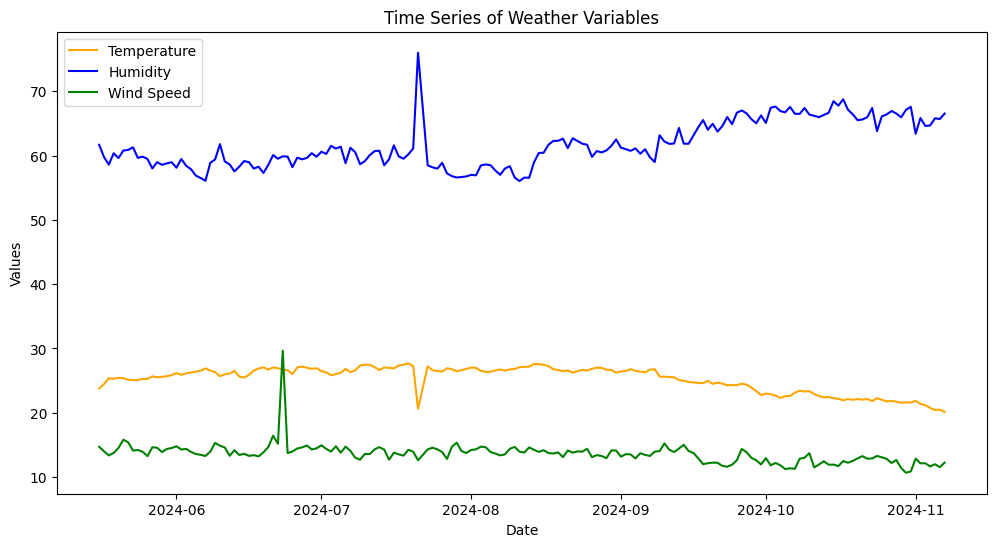

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, sum, min, max, to_date

# Assuming 'last_updated' column contains date information
# Replace 'last_updated' with the actual column name if different
data = data.withColumn("Date", to_date("last_updated", "yyyy-MM-dd"))  # Convert 'last_updated' column to date format and rename to 'Date'

# Calculate daily averages (grouping by Date)
time_series = data.groupBy("Date").avg("temperature_celsius", "humidity", "wind_kph").orderBy("Date")

# Collect data for plotting
dates = time_series.select("Date").rdd.flatMap(lambda x: x).collect()
avg_temps = time_series.select("avg(temperature_celsius)").rdd.flatMap(lambda x: x).collect()
avg_humidity = time_series.select("avg(humidity)").rdd.flatMap(lambda x: x).collect()
avg_wind_speed = time_series.select("avg(wind_kph)").rdd.flatMap(lambda x: x).collect()

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(dates, avg_temps, label="Temperature", color="orange")
plt.plot(dates, avg_humidity, label="Humidity", color="blue")
plt.plot(dates, avg_wind_speed, label="Wind Speed", color="green")
plt.title("Time Series of Weather Variables")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

Scatter Plots: Exploring Relationships Between Variables

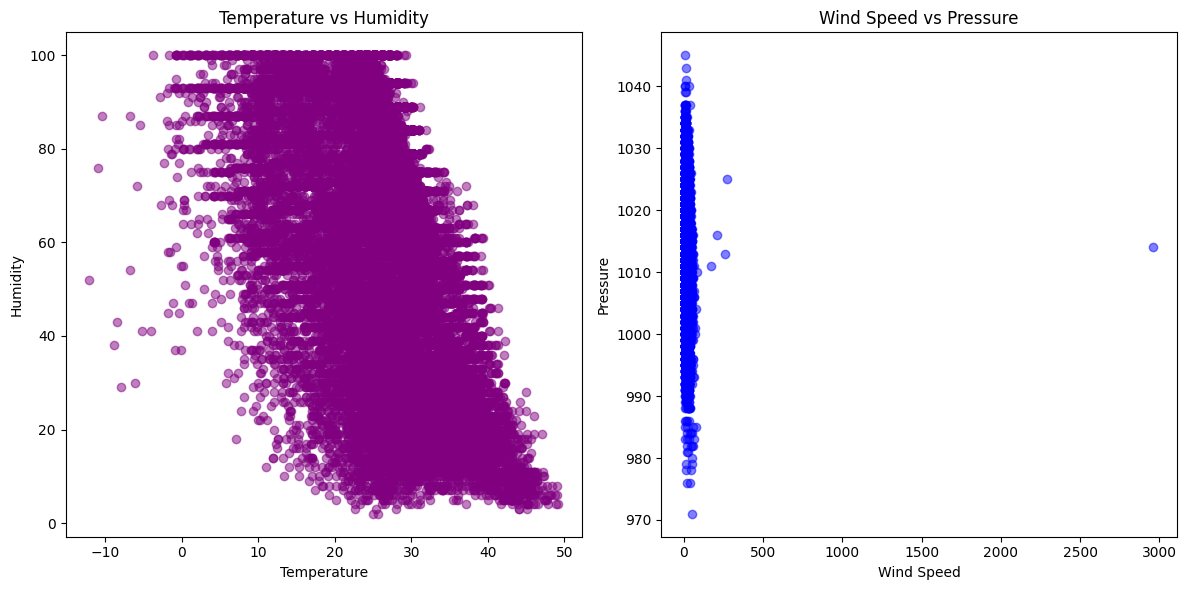

In [ ]:
# Collect data for Temperature vs. Humidity and Wind Speed vs. Pressure
# Use the correct column name 'temperature_celsius' instead of 'Temperature'
temperature = data.select("temperature_celsius").rdd.flatMap(lambda x: x).collect()

# Similarly, use correct column names for other variables (if incorrect)
# For example, 'humidity' and 'wind_kph' are likely the correct column names
humidity = data.select("humidity").rdd.flatMap(lambda x: x).collect()
wind_speed = data.select("wind_kph").rdd.flatMap(lambda x: x).collect()

# If 'Pressure' column exists, use it; otherwise, correct the name
pressure = data.select("pressure_mb").rdd.flatMap(lambda x: x).collect()  # Assuming 'pressure_mb' is the correct column name


# Plot scatter plots
plt.figure(figsize=(12, 6))

# Temperature vs Humidity
plt.subplot(1, 2, 1)
plt.scatter(temperature, humidity, alpha=0.5, color="purple")
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature")
plt.ylabel("Humidity")

# Wind Speed vs Pressure
plt.subplot(1, 2, 2)
plt.scatter(wind_speed, pressure, alpha=0.5, color="blue")
plt.title("Wind Speed vs Pressure")
plt.xlabel("Wind Speed")
plt.ylabel("Pressure")

plt.tight_layout()
plt.show()

Heatmaps: Visualize Correlations Between Variables

This part of the analysis focuses on examining the relationships between key weather variables—temperature, humidity, wind speed, and pressure—using a correlation heatmap. Correlation analysis helps us identify how these variables are associated with each other, providing insights into any linear relationships that may exist in the dataset. A heatmap is an effective visualization tool for this purpose, as it allows us to see positive and negative correlations at a glance.

Correlation Heatmap Analysis:

Objective:

To understand the relationships between weather variables in the dataset and identify any strong correlations that might reveal underlying patterns or dependencies.

Correlation Matrix:

A correlation matrix quantifies the relationships between variables, showing values between -1 and 1. A correlation near 1 indicates a strong positive relationship (as one variable increases, so does the other), while a value near -1 indicates a strong negative relationship (as one variable increases, the other decreases).
By calculating the correlation matrix for temperature, humidity, wind speed, and pressure, we aim to understand how these factors are connected.

Heatmap Visualization:

The heatmap uses color gradients to represent the strength and direction of each correlation. This allows us to quickly spot which variable pairs have high or low correlations, enhancing our understanding of how weather factors interact.

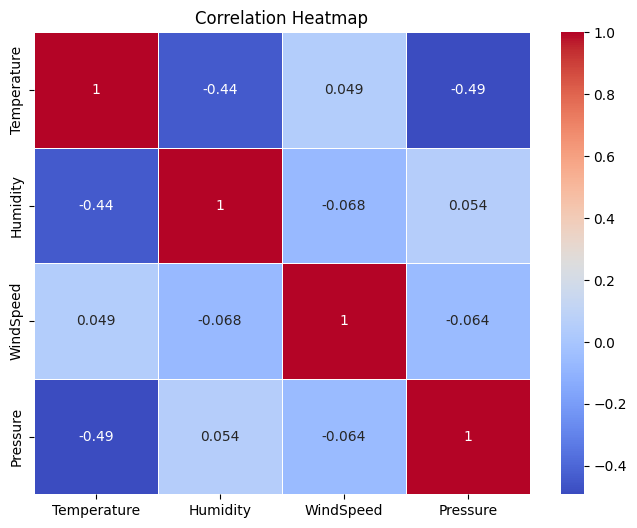

In [ ]:
import seaborn as sns
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
# Use the correct column names from your DataFrame
pandas_df = data.select("temperature_celsius", "humidity", "wind_kph", "pressure_mb").toPandas()

# Rename the columns to match the desired names
pandas_df = pandas_df.rename(columns={
    "temperature_celsius": "Temperature",
    "humidity": "Humidity",
    "wind_kph": "WindSpeed",
    "pressure_mb": "Pressure"
})

# Calculate correlation matrix
correlation_matrix = pandas_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Geographical Maps: Visualize Spatial Patterns

This part of the analysis utilizes a geographical map to visualize temperature data across different locations. By mapping weather data points using latitude and longitude, we can explore spatial patterns in temperature and examine how it varies by region. This type of visualization is especially useful for identifying geographical trends, such as warmer or cooler areas and clusters of similar temperature values.

In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(data.toPandas(), lat="latitude", lon="longitude", color="temperature_celsius", hover_name="location_name", hover_data=["temperature_fahrenheit", "humidity"])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(mapbox_zoom=2, mapbox_center={"lat": 0, "lon": 0})
fig.show()

--2024-11-07 12:31:26--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2024-11-07 12:31:27 ERROR 500: Internal Server Error.

Archive:  ne_110m_admin_0_countries.zip
replace ne_110m_admin_0_countries.README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ne_110m_admin_0_countries.README.html  
replace ne_110m_admin_0_countries.VERSION.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: ne_110m_admin_0_countries.VERSION.txt  
replace ne_110m_admin_0_countries.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: ne_110m_admin_0_countries.cpg  
replace ne_110m_admin_0_countries.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ne_110m_admin_0_countries

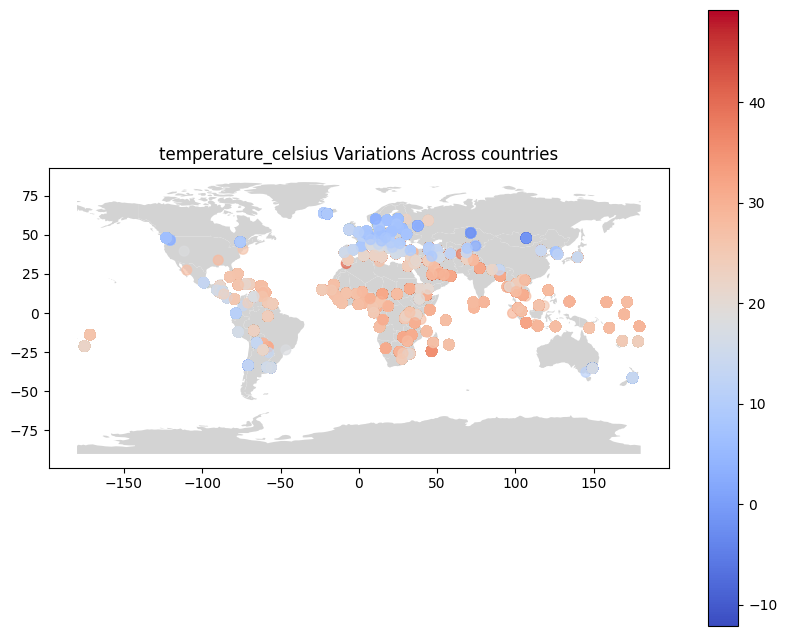

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Replace 'Latitude' and 'Longitude' with your column names, and convert to a Pandas DataFrame
pandas_df = data.select("temperature_celsius", "country", "Latitude", "Longitude").toPandas()

# Create a GeoDataFrame with Point geometries
geometry = [Point(xy) for xy in zip(pandas_df.Longitude, pandas_df.Latitude)]
geo_df = gpd.GeoDataFrame(pandas_df, geometry=geometry)

# Download the world map data from Natural Earth
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip

# Load the world map data
world = gpd.read_file("ne_110m_admin_0_countries.shp") # Load from the downloaded shapefile

# Plot the map with temperature_celsius color-coded
fig, ax = plt.subplots(figsize=(10, 8))
world.plot(ax=ax, color='lightgrey')

# Scatter plot with temperature_celsius
geo_df.plot(column="temperature_celsius", ax=ax, legend=True, cmap="coolwarm", markersize=50, alpha=0.7)
plt.title("temperature_celsius Variations Across countries")
plt.show()

# Time Series Analysis

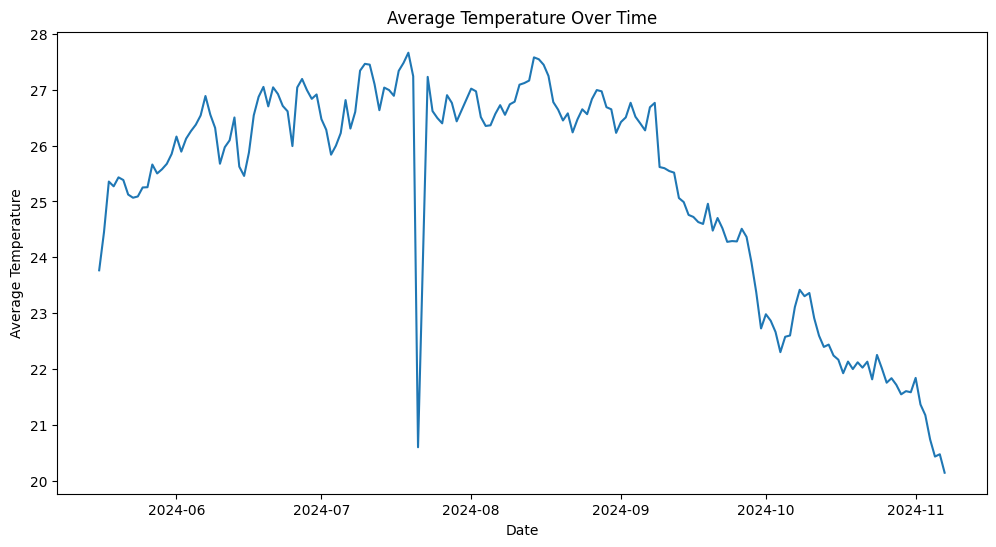

In [ ]:
from pyspark.sql.functions import to_date, col

# Convert 'Date' column to date format
data = data.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Group by date and calculate the average temperature
# Changed 'Temperature' to 'temperature_celsius'
daily_avg_temp = data.groupBy("Date").avg("temperature_celsius").orderBy("Date")

# Collect the data for plotting
dates = daily_avg_temp.select("Date").rdd.flatMap(lambda x: x).collect()
# Changed 'avg(Temperature)' to 'avg(temperature_celsius)'
avg_temps = daily_avg_temp.select("avg(temperature_celsius)").rdd.flatMap(lambda x: x).collect()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, avg_temps)
plt.title("Average Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Average Temperature")
plt.show()